In [1]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import random

### Define location of dataset folder, and define a list of filenames.

In [2]:
data_folder = 'DiaTrend_Dataset'  # Replace with your folder path

# Get all files matching the pattern 'SubjectN.xlsx'
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)
             if f.startswith('Subject') and f.endswith('.xlsx')]

### Load in the filenames of the dataset folder

In [3]:
subject_files = []

for file_path in all_files:
    # Extract the basename
    basename = os.path.basename(file_path)
    
    # Extract the number N from 'SubjectN.xlsx'
    # Remove 'Subject' prefix and '.xlsx' suffix
    subject_number = int(basename.replace('Subject', '').replace('.xlsx', ''))
    
    # Append a tuple of (subject_number, file_path)
    subject_files.append((subject_number, file_path))

# Sort the list based on subject numbers
subject_files.sort(key=lambda x: x[0])

### Train-test split. Randomly selected 80% of the files to train and the rest to test on. 

In [4]:
# Determine the split index
train_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(subject_files) * train_ratio)

# Split the list
train_subjects = subject_files[:split_index]
test_subjects = subject_files[split_index:]

# Extract the file paths
train_files = [item[1] for item in train_subjects]
test_files = [item[1] for item in test_subjects]

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")

Number of training files: 43
Number of testing files: 11


### Define the feature columns we are interested in.

In [5]:
# Define the columns you need from each sheet
bolus_columns = [
    'normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommendedCarb', 'recommended.net', 'recommended.correction', 'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard'
]

cgm_columns = [
    'mg/dl'  # Adjust to match the actual column name in your CGM sheet
]

### Define the Dataset. We select datapoints where there are CGM values as well as Bolus data values.

<p>A problem is that the CGM data is in a separate tab as the other data, which is in the Bolus tab. Another challenge is that Bolus data timestamp starts in 2021, 
    and the CGM data includes data from years several earlier.  I will analyze only the subset of CGM data that shares dates with those in the Bolus tab, but since the timestamps don't exactly match, I will round the timestamps to increase the likelihood of a match, and impute the CGM data as necessary by interpolation. </p>

In [6]:
class ExcelDataset(Dataset):
    def __init__(self, file_list, bolus_columns=None, cgm_columns=None, transform=None):
        self.file_list = file_list
        self.bolus_columns = bolus_columns
        self.cgm_columns = cgm_columns
        self.transform = transform

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        file_name = os.path.basename(file_path)
        
        # Read the specified sheets
        try:
            sheets = pd.read_excel(file_path, sheet_name=['Bolus', 'CGM'])
            bolus_data = sheets['Bolus']
            cgm_data = sheets['CGM']
        except Exception as e:
            print(f"Error reading sheets from {file_name}: {e}")
            return None

        # Normalize column names
        bolus_data.columns = bolus_data.columns.str.strip().str.lower()
        cgm_data.columns = cgm_data.columns.str.strip().str.lower()

        # Normalize selected columns
        bolus_columns_normalized = [col.strip().lower() for col in self.bolus_columns]
        cgm_columns_normalized = [col.strip().lower() for col in self.cgm_columns]

        # Ensure that all selected columns are present; add missing ones
        for col in bolus_columns_normalized:
            if col not in bolus_data.columns:
                bolus_data[col] = np.nan  # Assign NaN or appropriate default

        for col in cgm_columns_normalized:
            if col not in cgm_data.columns:
                cgm_data[col] = np.nan  # Assign NaN or appropriate default

        # Remove duplicates from the columns lists
        bolus_columns_normalized = list(dict.fromkeys(bolus_columns_normalized))
        cgm_columns_normalized = list(dict.fromkeys(cgm_columns_normalized))

        # Ensure 'date' is included only once
        if 'date' not in bolus_columns_normalized:
            bolus_columns_normalized.insert(0, 'date')

        if 'date' not in cgm_columns_normalized:
            cgm_columns_normalized.insert(0, 'date')

        # Select the required columns
        bolus_data = bolus_data[bolus_columns_normalized].copy()
        cgm_data = cgm_data[cgm_columns_normalized]

        # Handle 'date' columns
        if 'date' in bolus_data.columns:
            bolus_data['date'] = pd.to_datetime(bolus_data['date'], errors='coerce')
        else:
            print(f"'date' column not found in Bolus sheet of {file_name}")
            return None

        if 'date' in cgm_data.columns:
            cgm_data['date'] = pd.to_datetime(cgm_data['date'], errors='coerce')
        else:
            print(f"'date' column not found in CGM sheet of {file_name}")
            return None

        # Drop rows with invalid dates
        bolus_data = bolus_data.dropna(subset=['date'])
        cgm_data.dropna(subset=['date'], inplace=True)

        # Filter CGM data to the date range of Bolus data
        min_bolus_date = bolus_data['date'].min()
        max_bolus_date = bolus_data['date'].max()
        cgm_data = cgm_data[
            (cgm_data['date'] >= min_bolus_date) & (cgm_data['date'] <= max_bolus_date)
        ]

        if cgm_data.empty:
            print(f"No CGM data within Bolus date range in {file_name}")
            return None

        # Sort data by 'date'
        bolus_data = bolus_data.sort_values('date')
        cgm_data = cgm_data.sort_values('date')

        # Merge datasets using merge_asof
        merged_data = pd.merge_asof(
            bolus_data,
            cgm_data,
            on='date',
            direction='nearest',
            tolerance=pd.Timedelta('5min'),  # Adjust as needed
            suffixes=('', '_cgm')
        )

        # Drop rows where CGM data was not found within tolerance
        merged_data.dropna(subset=cgm_columns_normalized, inplace=True)

        # Check for null values
        if merged_data.empty:
            print(f"No data after merging in {file_name}")
            return None

        # Handle missing values
        merged_data = merged_data.fillna(0)

        # Optionally, drop 'date' column
        data_values = merged_data.drop(columns=['date']).values

        # Apply any transformations if transform is set
        if self.transform:
            data_values = self.transform(data_values)

        # Convert to tensor
        sequence = torch.tensor(data_values, dtype=torch.float32)

        # Check sequence length
        if len(sequence) < 2:
            print(f"Sequence too short in {file_name}, skipping.")
            return None

        # Prepare sequences
        input_sequence = sequence[:-1]
        target_sequence = sequence[1:]

        return input_sequence, target_sequence

### Remove empty batches. Since different batches may have different lengths, add padding to the sequences.

In [7]:
def collate_fn(batch):
    # Filter out any None returned due to errors in __getitem__
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None  # Skip this batch if it's empty after filtering
    
    # Separate inputs and targets
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Get sequence lengths
    input_lengths = torch.tensor([len(seq) for seq in inputs])
    
    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    return inputs_padded, targets_padded, input_lengths

### Define the feature normalization as well as the inverse (unnormalization) functions

In [8]:
def normalize(data):
    return (data - data_min) / (data_max - data_min + 1e-8)

def unnormalize(normalized_data):
    return normalized_data * (data_max - data_min + 1e-8) + data_min

### Create train and test datasets. Need a temp train_dataset in the beginning because we can't call normalization function as we don't yet have max-min values. 

In [9]:
# Create the training dataset with normalization
train_dataset = ExcelDataset(
    file_list=train_files,
    bolus_columns=bolus_columns,
    cgm_columns=cgm_columns,
    transform=normalize  # Apply normalization
)

# Create the test dataset with the same normalization
test_dataset = ExcelDataset(
    file_list=test_files,
    bolus_columns=bolus_columns,
    cgm_columns=cgm_columns,
    transform=normalize  # Apply normalization
)

# Create a temporary dataset without normalization
temp_train_dataset = ExcelDataset(
    file_list=train_files,
    bolus_columns=bolus_columns,
    cgm_columns=cgm_columns,
    transform=None  # No transformation applied
)

### Calculate the max and min values of the data.

In [10]:
def compute_normalization_params(dataset):
    all_data = []
    for data in dataset:
        if data is not None:
            inputs, _ = data  # inputs is a tensor
            all_data.append(inputs)
    
    all_data = torch.cat(all_data, dim=0)  # Concatenate all inputs
    data_min = all_data.min(dim=0)[0]  # Compute min per feature
    data_max = all_data.max(dim=0)[0]  # Compute max per feature
    return data_min.numpy(), data_max.numpy()

# Compute normalization parameters using the temporary dataset
data_min, data_max = compute_normalization_params(temp_train_dataset)

### Define the data loaders

In [11]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

### Define the LSTM model

In [12]:
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, input_size)  # Multiply by 2 for bidirectional
                
    def forward(self, x, lengths):
        # Pack the sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Pass through LSTM
        packed_output, _ = self.lstm(packed_input)
        
        # Unpack the sequences
        output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True)
        
        # Apply the fully connected layer to each time step
        output = self.fc(output)
        
        return output

### Set training hyperparameters

In [13]:
from torch.nn import SmoothL1Loss

# Determine input size from data
sample_input, _ = train_dataset[0]
input_size = sample_input.shape[1]  # Number of features in the input

hidden_size = 256
num_layers = 6
learning_rate = 0.001

model = LSTMPredictor(input_size, hidden_size, num_layers)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.RMSprop (model.parameters(), lr=learning_rate)

### Train the model on train_dataset.

In [15]:
num_epochs = 20
loss_values = []  # Initialize a list to store loss values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0  # Initialize total loss for this epoch
    batches_processed = 0  # Counter for batches processed
    
    for batch in train_loader:
        if batch is None:
            continue  # Skip empty batches
        inputs, targets, lengths = batch
        
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        
        # Flatten outputs and targets if necessary
        outputs_flat = outputs.view(-1, outputs.size(-1))
        targets_flat = targets.view(-1, targets.size(-1))
        
        # Compute the loss
        loss = criterion(outputs_flat, targets_flat)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        total_loss += loss.item()
        batches_processed += 1  # Increment the batch counter
    
    # Calculate the average loss for this epoch
    if batches_processed > 0:
        avg_loss = total_loss / batches_processed
    else:
        avg_loss = 0.0  # Avoid division by zero if no batches were processed
    
    # Append the average loss to the list
    loss_values.append(avg_loss)
    
    # Print the epoch number and average loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/20], Loss: 0.0117
Epoch [2/20], Loss: 0.0051
Epoch [3/20], Loss: 0.0441
Epoch [4/20], Loss: 0.0052
Epoch [5/20], Loss: 0.0035
Epoch [6/20], Loss: 0.0020
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0018
Epoch [9/20], Loss: 0.0019
Epoch [10/20], Loss: 0.0019
Epoch [11/20], Loss: 0.0020
Epoch [12/20], Loss: 0.0020
Epoch [13/20], Loss: 0.0018
Epoch [14/20], Loss: 0.0017
Epoch [15/20], Loss: 0.0017
Epoch [16/20], Loss: 0.0018
Epoch [17/20], Loss: 0.0016
Epoch [18/20], Loss: 0.0028
Epoch [19/20], Loss: 0.0022
Epoch [20/20], Loss: 0.0018


### Plot the loss function over epochs

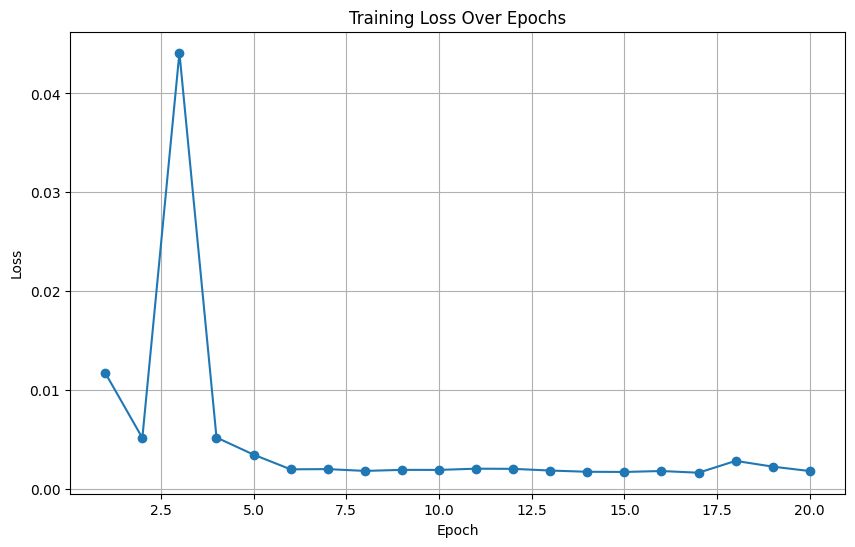

In [16]:
import matplotlib.pyplot as plt

# After training is complete, plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Evaluate the model - predict on the test_dataset

In [17]:
test_loader = DataLoader(
    test_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn
)

def evaluate_model(model, data_loader, criterion, data_min, data_max, cgm_feature_index):
    # Initialize
    model.eval()
    total_loss = 0.0
    total_batches = 0
    all_targets = []
    all_predictions = []

    # We will have to un-normalize the data to get it back to the original range
    def unnormalize(normalized_data):
        return normalized_data * (data_max - data_min + 1e-8) + data_min

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch is None:
                continue  # Skip empty batches
            inputs, targets, lengths = batch
            
            outputs = model(inputs, lengths)  # Shape: (batch_size, seq_length, feature_size)
            
            # Compute the loss
            outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
            targets_flat = targets.contiguous().view(-1, targets.size(-1))
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            total_batches += 1

            # Un-normalize outputs and targets
            outputs_unnorm = unnormalize(outputs.cpu())  # Shape: (batch_size, seq_length, feature_size)
            targets_unnorm = unnormalize(targets.cpu())

            # Extract CGM values using cgm_feature_index
            output_cgm_values = outputs_unnorm[:, :, cgm_feature_index]  # Shape depends on batch and seq length
            target_cgm_values = targets_unnorm[:, :, cgm_feature_index]

            # Flatten to 1D arrays
            output_cgm_values_flat = output_cgm_values.flatten()
            target_cgm_values_flat = target_cgm_values.flatten()

            # Convert to lists and extend all_targets and all_predictions
            all_targets.extend(target_cgm_values_flat.tolist())
            all_predictions.extend(output_cgm_values_flat.tolist())

    # Calculate average loss
    if total_batches > 0:
        avg_loss = total_loss / total_batches
    else:
        avg_loss = None  # Handle case with no batches

    # Convert lists to numpy arrays
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    return avg_loss, all_targets, all_predictions

### Calculate test loss, mean absolute error, and root-mean-square error.

In [19]:
data_columns = [
    'normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommendedCarb', 'recommended.net', 'recommended.correction',
    'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard', 'mg/dl'
]
# Evaluate the model
cgm_feature_index = data_columns.index('mg/dl')
test_loss, all_targets, all_predictions = evaluate_model(model, test_loader, criterion, data_min, data_max, cgm_feature_index)

print(f'Test Loss: {test_loss:.4f}')

# Compute metrics on un-normalized data
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Concatenate all targets and predictions
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

mae = mean_absolute_error(all_targets, all_predictions)
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))

print(f'Test MAE (un-normalized): {mae:.4f}')
print(f'Test RMSE (un-normalized): {rmse:.4f}')

Test Loss: 0.0050
Test MAE (un-normalized): 40.7928
Test RMSE (un-normalized): 55.0474


### Pick a sample from the test batch to visualize.

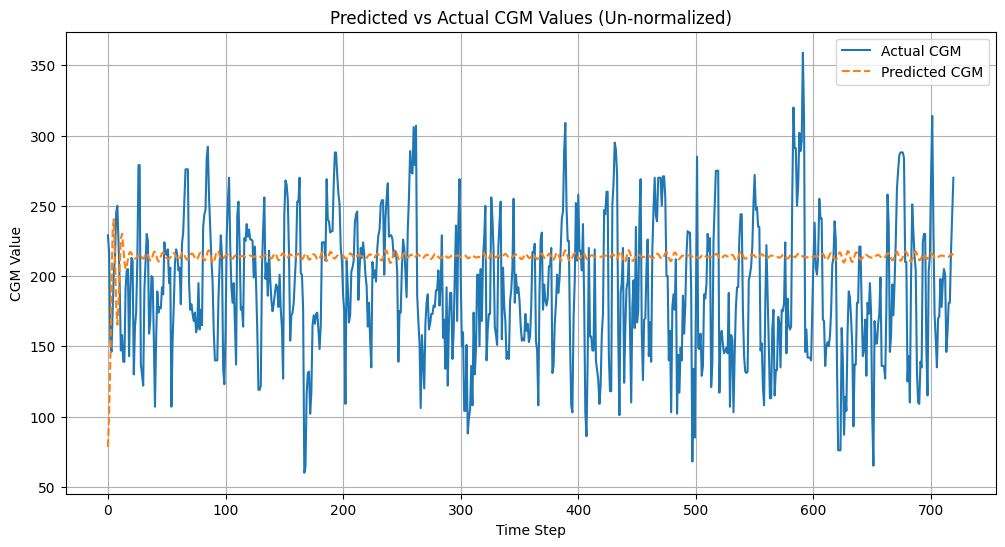

In [20]:
# Select a sample to visualize
sample_index = 0
inputs, targets, lengths = next(iter(test_loader))
outputs = model(inputs, lengths)

# Get the sequences
input_seq = inputs[sample_index, :lengths[sample_index]].cpu().numpy()
target_seq = targets[sample_index, :lengths[sample_index]].cpu().numpy()
output_seq = outputs[sample_index, :lengths[sample_index]].detach().cpu().numpy()

# Un-normalize sequences
input_seq = unnormalize(input_seq)
target_seq = unnormalize(target_seq)
output_seq = unnormalize(output_seq)

# Plotting
cgm_feature_index = data_columns.index('mg/dl')

plt.figure(figsize=(12, 6))
plt.plot(target_seq[:, cgm_feature_index], label='Actual CGM')
plt.plot(output_seq[:, cgm_feature_index], label='Predicted CGM', linestyle='--')
plt.title('Predicted vs Actual CGM Values (Un-normalized)')
plt.xlabel('Time Step')
plt.ylabel('CGM Value')
plt.legend()
plt.grid(True)
plt.show()

### Visualize all the outputs from the test batch

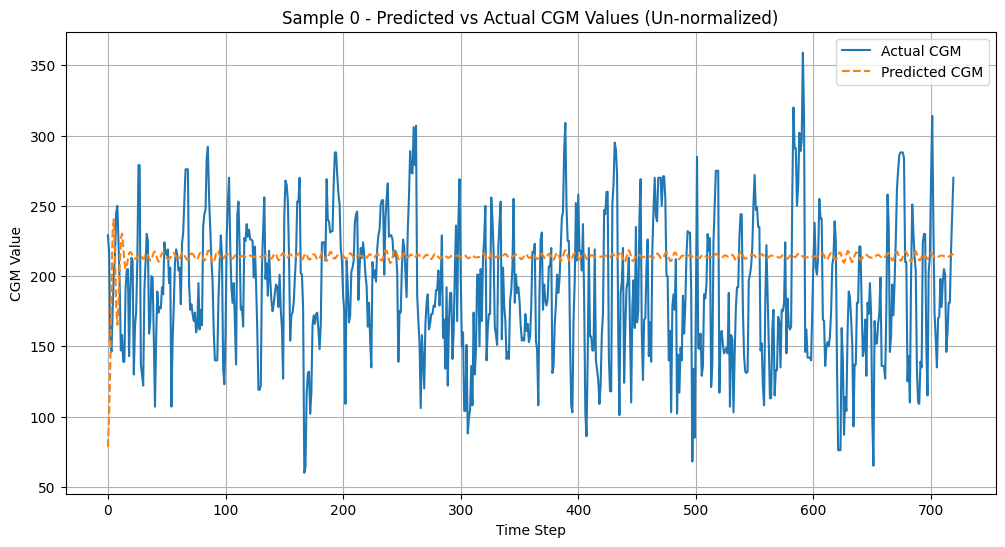

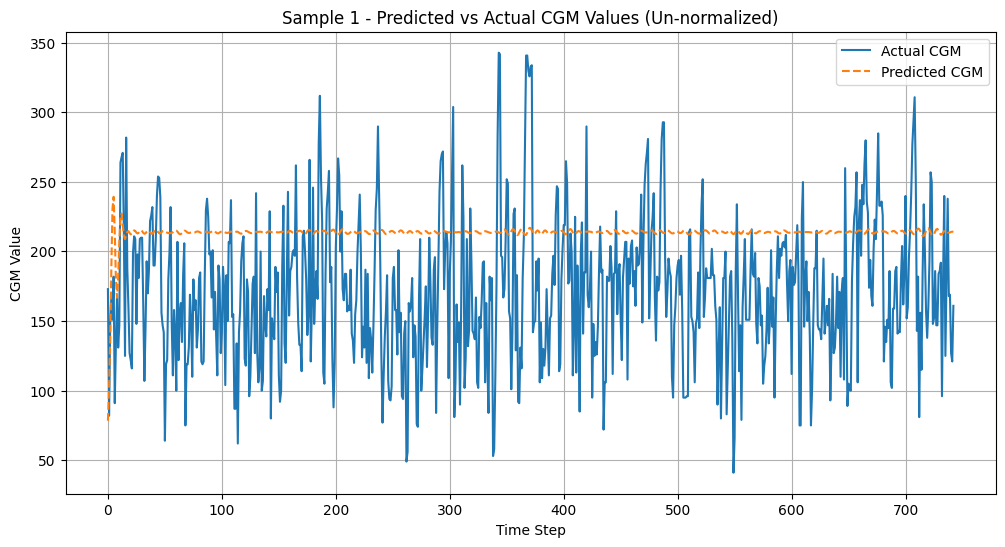

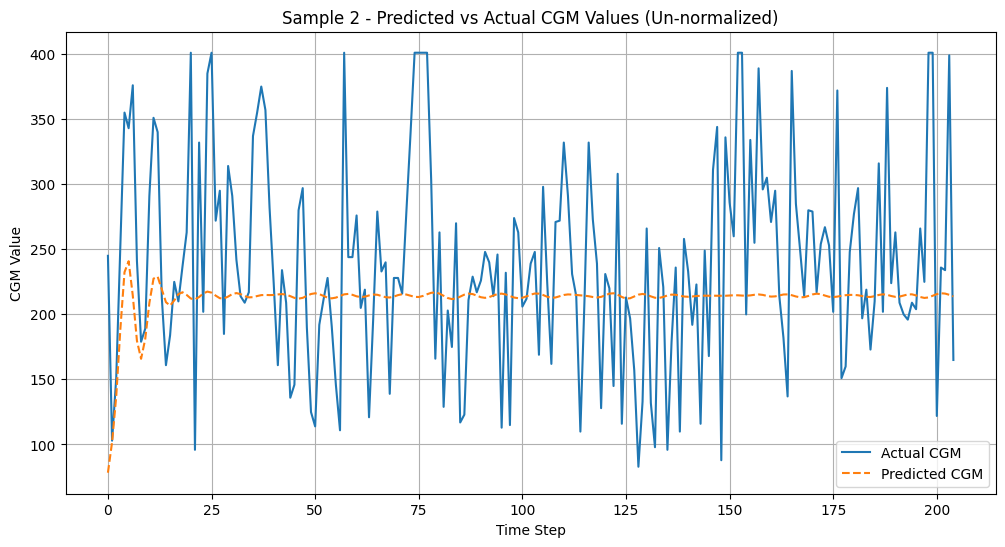

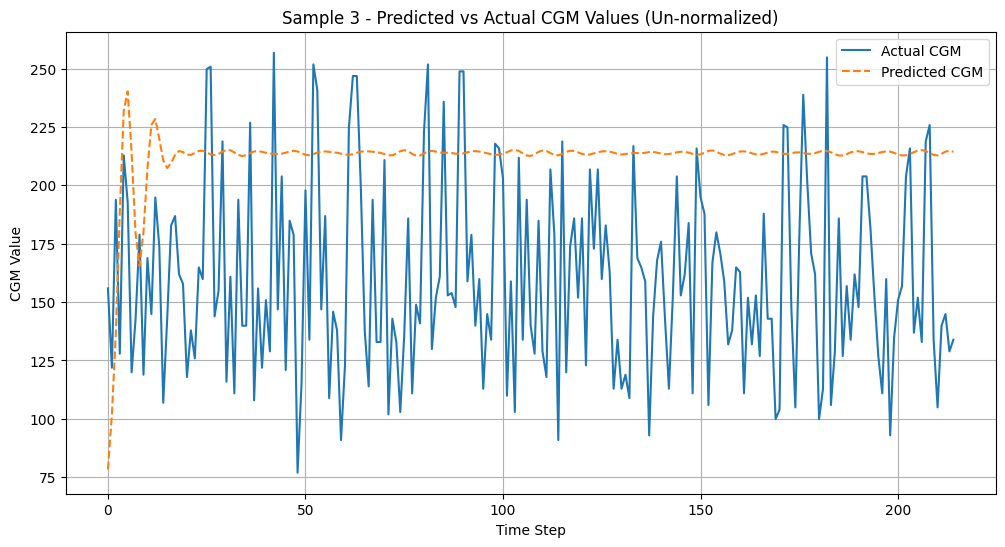

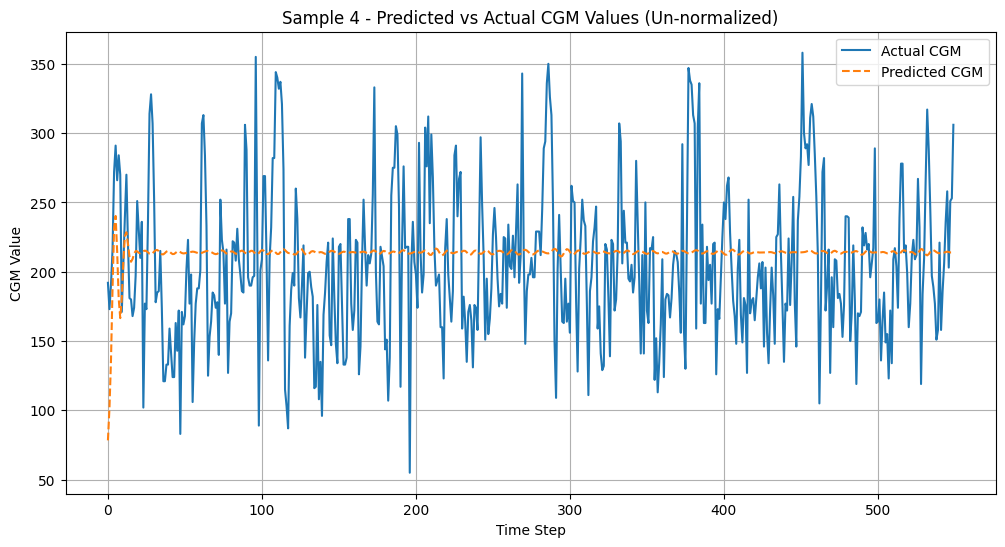

In [21]:
# Get the first batch from the test_loader
inputs, targets, lengths = next(iter(test_loader))

# Pass the inputs through the model to get outputs
outputs = model(inputs, lengths)

for sample_index in range(inputs.size(0)):
    # Extract sequences for the current sample
    seq_length = lengths[sample_index]
    input_seq = inputs[sample_index, :seq_length].cpu().numpy()
    target_seq = targets[sample_index, :seq_length].cpu().numpy()
    output_seq = outputs[sample_index, :seq_length].detach().cpu().numpy()

    # Un-normalize sequences
    input_seq = unnormalize(input_seq)
    target_seq = unnormalize(target_seq)
    output_seq = unnormalize(output_seq)

    # Extract the CGM values
    target_cgm = target_seq[:, cgm_feature_index]
    output_cgm = output_seq[:, cgm_feature_index]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(target_cgm, label='Actual CGM')
    plt.plot(output_cgm, label='Predicted CGM', linestyle='--')
    plt.title(f'Sample {sample_index} - Predicted vs Actual CGM Values (Un-normalized)')
    plt.xlabel('Time Step')
    plt.ylabel('CGM Value')
    plt.legend()
    plt.grid(True)
    plt.show()